In [1]:
import rasterio
import rasterio.plot
import numpy as np
from osgeo import gdal_array
from scipy.signal import savgol_filter
from scipy.interpolate import pchip_interpolate, InterpolatedUnivariateSpline
import math
from scipy.optimize import minimize
from scipy.optimize import Bounds
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def double_logistic_array(params,timeArr):
    phenology=[]
    for time in timeArr:
        phenology.append(double_logistic(params,time))
    return np.array(phenology)

def double_logistic(params,time):
    """Generate a double logistic curve similar 
    to those of the MODIS phenology product
    
    k1   --- curvature parmeter for first half of season
    k2   --- curvature parmeter for second half of season
    t01  --- timing parmeter for first half of season
    t02  --- timing parmeter for second half of season
    c    --- minimum LAI/NDVI etc
    d    --- maximum LAI/NDVI etc
    
    time --- time valueto evaluate the function 
    """
    k1  =params[0]
    k2  =params[1]
    t01 =params[2]
    t02 =params[3]
    c   =params[4]
    d   =params[5]
    lgstc1=(c-d)/(1.+math.exp(k1*(time-t01)))+d    
    lgstc2=(d-c)/(1.+math.exp(k2*(time-t02)))+c
    return np.min([lgstc1,lgstc2])
    
def genSynthObs(params,freq=1,stddev=0.0):
    
    time_arr=[]
    synth_obs=[]
    for t in range(1,365,freq):
        time_arr.append(t)
        obs=double_logistic(params,t)
        synth_obs.append(obs)
        
    return np.array(synth_obs),np.array(time_arr)

def phenology_differential(synth_obs):
    differential = []
    for i in range(len(synth_obs) -1):
        differential.append(synth_obs[i+1] - synth_obs[i])
    sos = differential.index(max(differential)) +1
    eos = differential.index(min(differential)) +1
    return sos, eos

def phenology_optimize(params,sosBounds,eosBounds):
    sos = sos_optimize(params,sosBounds)
    eos = eos_optimize(params,eosBounds)
    return sos, eos

def sos_optimize(params,sosBounds):
    func = lambda x: double_logistic(params,x)
    grad = lambda x0: approx_fprime(x0, func, epsilon=epsilon)
    
    sos_opt = minimize(fun = grad,
                       x0 = [params[2]],
                       bounds = sosBounds,
                       jac= '2-point',
                       options = {'ftol': 1e-1, 'gtol': 1e-6})
    return sos_opt.x

def eos_optimize(params,eosBounds):
    func = lambda x: double_logistic(params,x)
    grad = lambda x0: approx_fprime(x0, func, epsilon=epsilon)
    eos_opt = minimize(fun = grad,
                       x0 = [params[2]],
                       bounds = eosBounds,
                       jac= '2-point',
                       options = {'ftol': 1e-1, 'gtol': 1e-6})
    return eos_opt.x

def rmse(params,obs,obs_time):
    model=double_logistic_array(params,obs_time)
    rmse_series = np.sqrt(np.sum((model-obs)**2)/float(len(obs_time)))
    return rmse_series
    
def solver(params,obs,obs_time,costFunction,bounds):
    #costGradient, costHessian=ad.gh(costFunction)
    return minimize(costFunction,\
                    params,\
                    args=(obs,obs_time),\
                    bounds=bounds,\
                    #method='L-BFGS-B',\
                    jac='2-point',\
                    options={'gtol': 1e-6})

In [10]:
year = 2019
years = range(2017, 2020)  # 需要跑的起止年份，左开右闭区间
dates = np.arange(1, 365, 16).tolist() # 定义日期，MODIS从每年第一天到365天之间每隔16天一景

# 设置数据路径，大区域用 data，小区域用 data/smallRegions/
#base_path = r'data/'    # 完整的大区域
base_path = r'data/smallRegions/' # 小区域

# 读取样例数据，随便读任意一个就行，为了后面导出数据
src = rasterio.open(base_path + str(year) + '.tif')

# 参数范围限制，左边最小值，右边最大值
param_bounds = Bounds([0,0,65,235,0,0],[0.1,0.1,170,340,10000,10000])    # double logistic 的参数范围，参数含义见下
sosBounds = Bounds([65],[170])                                           # SOS 的范围，根据论文稍微扩展了 10 天左右
eosBounds = Bounds([235],[340])                                          # EOS 的范围，根据论文稍微扩展了 10 天左右
param_num = 6       # double logistic 参数个数

# 掩膜文件，大于 0 表示有数据， 小于等于 0 表示无数据，shapefile转栅格数据得到，分辨率和地理范围需要与影像一致。
mask_img_path = base_path + 'smallRegions.tif'
mask_img = gdal_array.LoadFile(mask_img_path)

## SG 滤波

100  of  3901 	 2.563445270443476 %
200  of  3901 	 5.126890540886952 %
300  of  3901 	 7.690335811330429 %
400  of  3901 	 10.253781081773903 %
500  of  3901 	 12.817226352217382 %
600  of  3901 	 15.380671622660858 %
700  of  3901 	 17.94411689310433 %
800  of  3901 	 20.507562163547806 %
900  of  3901 	 23.071007433991284 %
1000  of  3901 	 25.634452704434764 %
1100  of  3901 	 28.197897974878238 %
1200  of  3901 	 30.761343245321715 %
1300  of  3901 	 33.324788515765185 %
1400  of  3901 	 35.88823378620866 %
1500  of  3901 	 38.45167905665214 %
1600  of  3901 	 41.01512432709561 %
1700  of  3901 	 43.578569597539094 %
1800  of  3901 	 46.14201486798257 %
1900  of  3901 	 48.70546013842604 %
2000  of  3901 	 51.26890540886953 %
2100  of  3901 	 53.832350679313 %
2200  of  3901 	 56.395795949756476 %
2300  of  3901 	 58.95924122019996 %
2400  of  3901 	 61.52268649064343 %
2500  of  3901 	 64.0861317610869 %
2600  of  3901 	 66.64957703153037 %
2700  of  3901 	 69.21302230197385 %
28

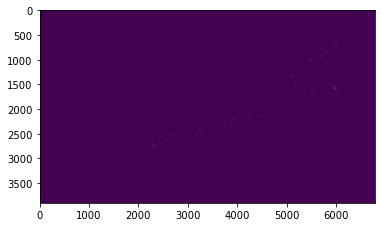

In [11]:
for year in years:
    raw_img_path = base_path + str(year) + '.tif'
    out_img_path = base_path + str(year) + '_filtered.tif'
    raw_img = gdal_array.LoadFile(raw_img_path)
    src = rasterio.open(base_path + str(year) + '.tif')
    [doy, img_ht, img_wd] = raw_img.shape
    filtered_img = np.zeros((doy, img_ht, img_wd))
    
    # SG滤波，参数可调整
    for x in range(1,img_ht):
        # 打印进度信息，因为SG滤波耗时较长。
        if x%100 == 0:
            print(x, ' of ', img_ht, '\t', x/img_ht *100, '%')
        for y in range(1,img_wd):
            if mask_img[x,y] > 20:      # 只对区域内数据处理
                series = raw_img[:,x,y] # 获取原始影像时间序列
                filtered_series = savgol_filter(series, 5, 3) # SG滤波
                filtered_img[:,x,y] = filtered_series # 滤波后存储到新影像中
            else:
                continue
   
    # 把滤波后的时间序列存储到新的影像中
    with rasterio.open(
        out_img_path,
        'w',
        driver='GTiff',
        height=filtered_img.shape[1],
        width=filtered_img.shape[2],
        count=filtered_img.shape[0],
        dtype=rasterio.int16, #存储数据精度为 Int16
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(filtered_img.astype(np.int16)) 

    
plt.imshow(filtered_img[10,:,:])
print(filtered_img.shape)

## double logistic 拟合

In [ ]:
for year in years:
    # 读取滤波后的影像
    mask_img_path = base_path + r'smallregions.tif'
    mask_img = gdal_array.LoadFile(mask_img_path)
    filtered_img_path = base_path + str(year) + '_filtered.tif'
    filtered_img = gdal_array.LoadFile(filtered_img_path)
    out_param_path = base_path + str(year) + '_params.tif'
    out_rmse_path = base_path + str(year) + '_rmse.tif'
    [doy, img_ht, img_wd] = filtered_img.shape              # 影像的维度（日期数、宽、高）
    param_num = 6       # double logistic 参数个数

    #fitted_img = np.zeros(filtered_img.shape)
    fitted_params = np.zeros((param_num, img_ht, img_wd))
    fitted_rmse = np.zeros((1, img_ht, img_wd))
    

    # 分配影像日期(DOY)
    time_arr=np.arange(1, 365, 16)

    # 开始计时
    start = time.time()
    for x in range(1,img_ht):
        # 打印进度信息，因为影像较大。
        if x%100 == 0:
            end = time.time()
            print(x, ' of ', img_ht, '\t', x/img_ht *100, '%\t Time elapsed: ', str(end - start) )

        for y in range(1,img_wd):
            # 如果序列全为 0，则不需要做拟合（研究区外）
            if mask_img[x,y] > 1:
                series = filtered_img[:,x,y] # 获取原始影像时间序列

                # Double logistic 拟合参数的初始猜测
                params=np.zeros(6)
                params[0]=0.2
                params[1]=0.4
                params[2]=120
                params[3]=250
                params[4]=np.min(series)
                params[5]=np.max(series)

                # 初始猜测参数的时间序列曲线
                phenology=double_logistic_array(params,time_arr)
                #synth_obs, obs_times=genSynthObs(params,freq=16,stddev=0.05,cloud=0)

                # 滤波后的观测时间序列曲线
                synth_obs = series #/ 10000
                obs_times = time_arr

                # 经过优化后的 double logiscit 参数值和 RMSE 值
                s=solver(params,synth_obs,obs_times,rmse,param_bounds)
                rmse_series = s.fun

                # double logistic 拟合后的时间序列
                #fitted_img[:,x,y]=double_logistic_array(s.x,time_arr)
                fitted_params[:,x,y] = s.x
                fitted_rmse[0,x,y] = s.fun

    # 把滤波后的时间序列存储到新的影像中
    with rasterio.open(
        out_param_path,
        'w',
        driver='GTiff',
        height=fitted_params.shape[1],
        width=fitted_params.shape[2],
        count=fitted_params.shape[0],
        dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
        crs = rasterio.crs.CRS.from_epsg(4326),
        transform=src.transform,
    ) as dst:
        dst.write(fitted_params) 

    
    src = rasterio.open("data/" + str(2019) + '.tif')
    with rasterio.open(
        out_param_path,
        'w',
        driver='GTiff',
        height=fitted_rmse.shape[1],
        width=fitted_rmse.shape[2],
        count=fitted_rmse.shape[0],
        dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
        crs = rasterio.crs.CRS.from_epsg(4326),
        transform=src.transform,
    ) as dst:
        dst.write(fitted_rmse) 

100  of  3901 	 2.563445270443476 %	 Time elapsed:  41.862504959106445
200  of  3901 	 5.126890540886952 %	 Time elapsed:  49.093217611312866
300  of  3901 	 7.690335811330429 %	 Time elapsed:  51.662596225738525
400  of  3901 	 10.253781081773903 %	 Time elapsed:  53.92018151283264
500  of  3901 	 12.817226352217382 %	 Time elapsed:  57.8357150554657
600  of  3901 	 15.380671622660858 %	 Time elapsed:  65.05858731269836
700  of  3901 	 17.94411689310433 %	 Time elapsed:  66.16465973854065
800  of  3901 	 20.507562163547806 %	 Time elapsed:  107.89742922782898
900  of  3901 	 23.071007433991284 %	 Time elapsed:  137.98108315467834
1000  of  3901 	 25.634452704434764 %	 Time elapsed:  186.07334804534912
1100  of  3901 	 28.197897974878238 %	 Time elapsed:  236.5495204925537
1200  of  3901 	 30.761343245321715 %	 Time elapsed:  257.34312295913696
1300  of  3901 	 33.324788515765185 %	 Time elapsed:  262.8214919567108
1400  of  3901 	 35.88823378620866 %	 Time elapsed:  305.8902585506439


## SOS EOS 提取

In [ ]:
for year in range(years)
    # 读取滤波后的影像
    param_img_path = base_path + str(year) + '_params.tif'
    param_img = gdal_array.LoadFile(param_img_path)
    mask_img_path = base_path + str(year) + 'smallregions.tif'
    mask_img = gdal_array.LoadFile(mask_img_path)
    out_sos_path = base_path + str(year) + '_sos.tif'
    out_eos_path = base_path + str(year) + '_eos.tif'
    out_los_path = base_path + str(year) + '_los.tif'

    [doy, img_ht, img_wd] = param_img.shape              # 影像的维度（日期数、宽、高）

    # 分配内存给物候期结果
    sos_img = np.zeros((1, img_ht, img_wd))
    eos_img = np.zeros((1, img_ht, img_wd))
    los_img = np.zeros((1, img_ht, img_wd))

    # 分配影像日期(DOY)
    time_arr=np.arange(1, 365, 16)

    # 开始计时
    start = time.time()
    for x in range(1,img_ht):
        # 打印进度信息，因为影像较大。
        if x%100 == 0:
            end = time.time()
            print(x, ' of ', img_ht, '\t', x/img_ht *100, '%\t Time elapsed: ', str(end - start) )
        for y in range(1,img_wd):
            # 如果序列全为 0，则不需要做拟合（研究区外）
            if mask_img[x,y] > 3:
                params = param_img[:,x,y] # 获取拟合参数
                sos_img[0,x,y], eos_img[0,x,y] = phenology_optimize(params,sosBounds,eosBounds)

    los_img = sos_img - eos_img
    
    # 存储 SOS 影像
    with rasterio.open(
        out_sos_path,
        'w',
        driver='GTiff',
        height=sos_img.shape[1],
        width=sos_img.shape[2],
        count=sos_img.shape[0],
        dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(sos_img)

    # 存储 EOS 影像
    with rasterio.open(
        out_eos_path,
        'w',
        driver='GTiff',
        height=eos_img.shape[1],
        width=eos_img.shape[2],
        count=eos_img.shape[0],
        dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(eos_img)
        
    # 存储 LOS 影像
    with rasterio.open(
        out_eos_path,
        'w',
        driver='GTiff',
        height=los_img.shape[1],
        width=los_img.shape[2],
        count=los_img.shape[0],
        dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(los_img)

In [17]:
year = 2019
out_sos_path = "data/" + str(year) + '_sos.tif'            
src = rasterio.open("data/" + str(year) + '.tif')
with rasterio.open(
    out_sos_path,
    'w',
    driver='GTiff',
    height=sos_img.shape[1],
    width=sos_img.shape[2],
    count=sos_img.shape[0],
    dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(sos_img)

out_eos_path = "data/" + str(year) + '_eos.tif'            
with rasterio.open(
    out_eos_path,
    'w',
    driver='GTiff',
    height=eos_img.shape[1],
    width=eos_img.shape[2],
    count=eos_img.shape[0],
    dtype=rasterio.float64, #存储数据精度为 float64,参数精度要求较高
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(eos_img)